In [2]:
import pandas as pd
import numpy as np
import sklearn.cluster
import scipy
import sklearn.cluster

# Read DataFrame df from csv file
# Note: some of these elements will be NaN because the csv file has some missing values,
# i.e. two adjacent commas with nothing between them.
df = pd.read_csv("F00005811-WV6_Data_ascii_delimited_v_2016_01_01/WV6_Data_ascii_delimited_v_2016_01_01.dat")

In [3]:
# Specification (.sts) file with description string for each survey item
specfile = "F00005811-WV6_Data_ascii_delimited_v_2016_01_01/WV6_Data_ascii_delimited_v_2016_01_01.sts"

def represents_int(s):
    '''
    represents_int determines whether its argument is a string that
    represents and integer.
    '''
    try: 
        int(s)
        return True
    except ValueError:
        return False

def read_spec(filename):
    '''
    read_spec reads the World Value Survey .sts specification file for "Wave 6."
    It returns a series where the index is a code for each column and 
    the value is a descriptive string.
    This file contains code descriptions for the 430 codes in Wave 6.
    '''
    s = pd.Series([])
    with open(filename, "r") as file:
        for line in file:
            # An example line from the spec file is:
            #    V4 5 (F2) [<= -1] {Important in life: Family} \V4
            # All we care about from this line is arr[0], which is "V4", 
            # and what's in brackets {}
            arr = line.split()
            if len(arr) < 2 or not represents_int(arr[1]):
                continue
            # The "code" is a string of letters and numbers, like "V4" or "MN_228R" 
            code = arr[0]
            # Need to parse the code description in between the { and }
            # There may be spaces inside the description, so the description may span
            # several elements
            desclist = [i for i, x in enumerate(arr) if "{" in x or "}" in x]
            # Some lines might not be a description of a code; they won't have brackets { }
            if not desclist:
                continue
            desc = ""
            min = desclist[0]
            max = desclist[-1]
            for i in range(min, max + 1):
                desc += arr[i]
                if i < max:
                    desc += " "
            # Append the code: desc pairs one by one
            sapp = pd.Series({code: desc})
            s = s.append(sapp)
    return s

spec_series = read_spec(specfile)

In [4]:
# Set column names to the codes from the .sts specifications file
df.columns = spec_series.index

In [5]:
def subcluster(X):
    '''
    This function is used to take a single cluster and break it into one or two subclusters.
    This is useful because our clusters will contain both correlated and anticorrelated
    components.  We want to distinguish between these sets of components.
    Note, however, that we cannot interpret this result without resorting to a manual
    check of the .sts specifications file to see whether that survey item
    had low numbers = most positive opinion or high numbers = most positive opinion
    '''
    kmeans = sklearn.cluster.KMeans(n_clusters=2)
    kmeans.fit(X)
    p = kmeans.predict(X)
    c = np.corrcoef([row for row in X])
    # Add the R-squared values for every cross-cluster pair
    # with a minus sign when R is negative.  If the result is negative, it means
    # the clusters are anticorrelated and there should be two clusters.  
    # Otherwise, there should be one.
    csum = sum(np.sign(c[i,j])*c[i, j]**2 
                for i, v in enumerate(p) 
                for j, w in enumerate(p) if v != w)   
    #The following code can be used to check the number of subclusters in each cluster
    #string = "Mini-cluster sum: " + str(csum)
    #if csum > 0:
    #    string += "(1 cluster)"
    #else:
    #    string += "(2 clusters)"
    #print(string)
    if csum < 0:
        return p # There should be two clusters
    else:
        return np.zeros(len(X)) # There should be only one cluster

def find_bad_nums(df, numrows, threshold, min, max):
    '''
    Given a DataFrame, find the numbers of the columns where more than
    10% of the rows are -4.  This means they were not included in the
    survey for 10% or more of the respondents.  I don't want to attempt to fill
    in the -4's with mean values if there are too many -4's.
    '''
    badlst = []
    for n in range(min, max):
        try:
            frac = df[df.columns[n]].value_counts()[-4] / numrows
            if frac > 0.1:
                badlst.append(n)
        except KeyError:
            pass
    return badlst

def custom_dist(row1, row2):
    '''
    The custom distance is the minimum of the usual distance
    along with the distance between one and the negative of the other.
    '''
    return min(
        np.sqrt(np.sum((row1 - row2)**2)),
        np.sqrt(np.sum((row1 + row2)**2))
    )

def get_all_nums(bad_nums):
  # These are the numbers for Inglehart's traditional vs. secular-rational items
  # I had to look these up manually from Inglehart's book
  trad_nums = [173, 344, 236, 392, 391, 10, 51, 170, 26, 
               112, 168, 240, 9, 239, 88, 99, 237, 49, 5, 150]
  trad_nums = np.array(trad_nums)-1 # column number equals printed number minus one
  trad_nums = [a for a in trad_nums if a not in bad_nums]

  # These are the numbers of Inglehart's survival vs. self-expression items        
  # I had to look these up manually from Inglehart's book
  surv_nums = [343, 11, 234, 89, 25, 53, 62, 56, 41, 39, 40, 101, 
               12, 47, 102, 57, 54, 43, 14, 16, 17, 7, 6, 148, 90, 161]
  surv_nums = np.array(surv_nums)-1
  surv_nums = [a for a in surv_nums if a not in bad_nums]

  # Group the two lists together.  Let's see if clustering can separate them again
  all_nums = trad_nums + surv_nums
  return all_nums, trad_nums, surv_nums

def get_zscore_matrix(df, numrows, all_nums):
  '''
  Given a DataFrame, a number of rows, and a list of column numbers (all_nums)
  Generate a zscore matrix, which is transposed relative to the DataFrame.
  The zscore matrix has rows that add to zero, their variance is 1, and each
  row in the zscore matrix corresponds to a column of the DataFrame.
  '''
  # Turn the df columns into rows (transpose) and select those rowse corresponding to all_nums
  X = df2.iloc[0:numrows].T.iloc[all_nums].as_matrix() # matrix of questions from start to end
  # insert nan wherever X < 0.  Note, this will trigger a runtime warning
  # saying that X < 0 results in some nan value where X is already nan. 
  # That's fine, those values are already nan and will remain nan.
  X[X < 0] = np.nan 
  # compute the mean of each survey item, averaging over all respondents
  row_means = np.nanmean(X, axis=1)
  # find the indices of the nans so that we can replace them by the mean value
  inds = np.where(np.isnan(X))
  # insert the row means in place of the nans
  X[inds] = np.take(row_means, inds[0])
  # Replace the respondents' answers by their z-scores for each survey item.
  # This is necessary so that we can perform a cluster analysis, since different
  # survey items are on wildly different scales.
  X = scipy.stats.zscore(X, axis=1)
  return X

def get_subc_list(X, labels):
  '''
  Get a list of subclusters for each cluster.
  Each item within a cluster is coded as either 0 or 1 using the subcluster function
  defined in this file.  Please see the subcluster function for further details.
  '''
  # indlist = [[row indices of X where cluster label = 0], [indices where label = 1], ...]
  indlist = [np.where(labels == a) for a in sorted(np.unique(labels))]
  # subXlist = [X rows where label = 0, X rows where label = 1, ... ]
  subXlist = [X[inds[0]] for inds in indlist] # inds will be a 1-elt. tuple, so take inds[0]
  # inv = [[predictions for label = 0], [predictions for label = 1], ...]
  # each prediction will be either 0 or 1 depending on how this item is inverted relative to
  # the other items in the cluster.  All the 0's are correlated with each other and
  # anticorrelated with the 1's.
  subc_list = [subcluster(subX) for subX in subXlist]
  return subc_list



In [6]:
while 1:
  print("Would you like to analyze:")
  print("(a) the world, two clusters")
  print("(b) the world, four clusters")
  print("(c) United States, two clusters")
  print("(d) United States, four clusters")
  letter = input(">")
  if letter in list("abcd"):
    break
  else:
    print("Input error: please enter a letter a-d")

dpref = {"a": -700, "b": -500, "c": -110, "d": -75}
dcode = {"c": 840, "d": 840}
dname = {"a": "the world", "b": "the world", "c": "the United States", "d": "the United States"}
numcols = len(df.columns)

if letter == "a" or letter == "b":
  df2 = df.copy() # the world
else:
  df2 = df[df['V2'] == dcode[letter]].copy() # U.S. only
numrows = len(df2.index)

# These are the numbers for "bad" survey items (columns) where more than 10% of the data is NaN.
# Many of these have much more than 10% being NaN.
# min survey item = 4 because the first four items in the list are not really survey items
bad_nums = find_bad_nums(df, numrows, threshold = 0.1, min = 4, max=numcols)

all_nums, trad_nums, surv_nums = get_all_nums(bad_nums)

all_nums.sort()

print("The number of good survey items for", dname[letter], "is: ", len(all_nums))
print("The number of respondents for", dname[letter], "is: ", numrows)

# The preference value for Affinity Propagation has to be set via trial and error.
# The smaller it is, the fewer clusters will appear.
# If it is too small, there will be only one cluster.
clust = sklearn.cluster.AffinityPropagation(affinity="precomputed", preference = dpref[letter])

X = get_zscore_matrix(df2, numrows, all_nums)

# Compute affinity matrix.  The affinity should be small when two items are far apart.
# That means we need to take the negative of the distance between the items.
# Also, we want to note correlations _and_ anticorrelations.  That means we should
# compute both the distance between row1 and row2 _and_ the distance between
# row1 and -row2.  We then take the minimum of these as the user-defined distance.
# In other words, [1, 0, -1, 0] should be "the same as" [-1, 0, 1, 0].
Xaff = -np.array(
                  [[custom_dist(row1, row2) for row1 in X] 
                  for row2 in X]
                )

clust.fit(Xaff)
labels = clust.labels_

# Now we have to determine if each survey item in each cluster was correlated or anticorrelated
# with the other survey items
subc_list = get_subc_list(X, labels)

print("How to interpret these resuls:")
print("")
print("Clustering was performed by Affinity Propagation.")
print("The number 0, 1, 2, or 3 is the cluster number.  All 0's are in the same cluster.")
print("Surv-Exp means that this item is classified as Survival vs. Self-Expression by Inglehart.")
print("Trad-Sec means that this item is classified as Traditional vs. Secular by Inglehart.")
print("The phrase in brackets { } describes the nature of the item.")
print("")
print("A's are correlated with other A's and anticorrelated with B's in that cluster.")
print("However, to interpret this you need to know whether the scale on that item runs from e.g.")
print("1 (highest) to 5 (lowest) or the reverse.  This requires manually consulting a table.")
print("")
print("")

predlist = [(a[1],
             "Trad-Sec" if all_nums[a[0]] in trad_nums else "Surv-Exp",
             spec_series.iloc[all_nums[a[0]]],
             all_nums[a[0]]
            ) for a in enumerate(labels)]
# Sort by cluster, then by survey item number
predlist.sort(key = lambda x: (x[0], x[3]))
joinedlist  = []
for i in subc_list:
    joinedlist = joinedlist + list(i)
# joinedlist is sorted in the same way as predlist, so they can be zipped
for x, i in zip(predlist, joinedlist):
    print("A" if i==1 else "B", x[0:3])

Would you like to analyze:
(a) the world, two clusters
(b) the world, four clusters
(c) United States, two clusters
(d) United States, four clusters
>d
The number of good survey items for the United States is:  31
The number of respondents for the United States is:  2232


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in less


How to interpret these resuls:

Clustering was performed by Affinity Propagation.
The number 0, 1, 2, or 3 is the cluster number.  All 0's are in the same cluster.
Surv-Exp means that this item is classified as Survival vs. Self-Expression by Inglehart.
Trad-Sec means that this item is classified as Traditional vs. Secular by Inglehart.
The phrase in brackets { } describes the nature of the item.

A's are correlated with other A's and anticorrelated with B's in that cluster.
However, to interpret this you need to know whether the scale on that item runs from e.g.
1 (highest) to 5 (lowest) or the reverse.  This requires manually consulting a table.


B (0, 'Trad-Sec', '{Important in life: Family}')
B (0, 'Trad-Sec', '{Important in life: Work}')
B (0, 'Trad-Sec', '{Important in life: Religion}')
A (0, 'Surv-Exp', '{Important child qualities: Imagination}')
A (0, 'Trad-Sec', '{Active/Inactive membership: Church or religious organization}')
B (0, 'Trad-Sec', '{One of my main goals in life 

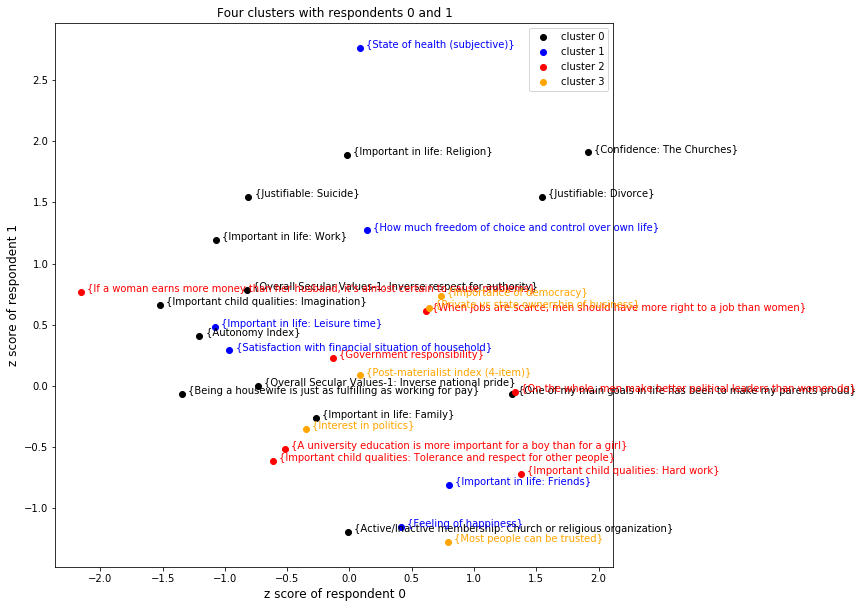

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_pair_respondents(m, n, labels, matrix, spec_series, all_nums):
  '''
  Plot respondents m and n's z-scores
  '''
  clusterlist = [[a[0] for a in enumerate(labels) if a[1] == i] for i in range(0, 4)]

  plt.figure(figsize=(10,10))

  col = ['black', 'blue', 'red', 'orange']

  for i, c in enumerate(clusterlist):
    plt.plot(matrix[c,m], matrix[c,n], 'o', label = 'cluster ' + str(i), color = col[i])

  plt.title("Four clusters with respondents " + str(m) + " and " + str(n))
  plt.legend()
  plt.xlabel("z score of respondent " + str(m), size='large')
  plt.ylabel("z score of respondent " + str(n), size='large')

  #print(clusterlist)
  #print(spec_series[all_nums])

  for c in enumerate(clusterlist):
    for i in c[1]:
      plt.annotate(spec_series.iloc[all_nums[i]], (matrix[i,m] + 0.05, matrix[i,n]), color = col[c[0]])

  plt.savefig("respondents-" + str(m) + "-" + str(n) + ".jpg")
    
plot_pair_respondents(0, 1, labels, X, spec_series, all_nums)

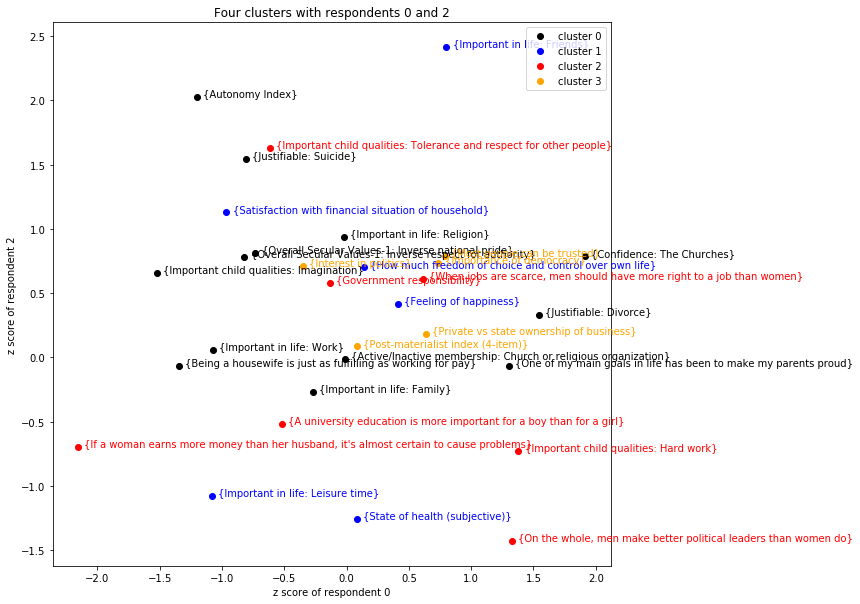

In [8]:
plot_pair_respondents(0, 2, labels, X, spec_series, all_nums)

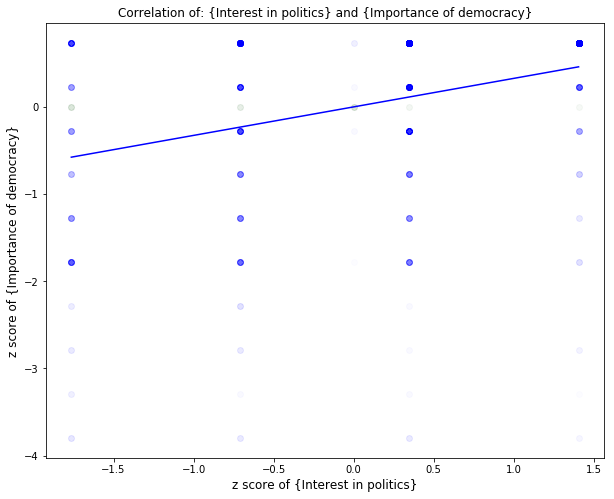

In [16]:
def plot_pair_items(m, n, mparity, nparity, matrix, spec_series, all_nums):
  '''
  Plot survey items m and n's z-scores
  There should almost always be points at z = 0; these correspond to missing data. 
  '''

  plt.figure(figsize=(10,8))

  matm = matrix[m, :] if mparity == 1 else -matrix[m, :]
  matn = matrix[n, :] if nparity == 1 else -matrix[n, :]

  nonzero = list(zip(*[a for a in zip(matm, matn) if a[0] != 0 and a[1] != 0]))
  mzer = zip(*[a for a in zip(matm, matn) if a[0] == 0 and a[1] != 0])
  nzer = zip(*[a for a in zip(matm, matn) if a[0] != 0 and a[1] == 0])
  zer = zip(*[a for a in zip(matm, matn) if a[0] == 0 and a[1] == 0])    

  alpha = 0.01
  z = 'green'
  nz = 'blue'
  plt.plot(*nonzero, color = nz, marker = 'o', alpha = alpha, linestyle='None')
  plt.plot(*mzer, color=z, marker='o', alpha = alpha, linestyle='None')
  plt.plot(*nzer, color=z, marker='o', alpha = alpha, linestyle='None')
  plt.plot(*zer, color=z, marker='o', alpha = alpha, linestyle='None')

  x, y = matm, matn
  plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'b-')

  plt.title("Correlation of: " + spec_series.iloc[all_nums[m]] + " and " + spec_series.iloc[all_nums[n]])
  plt.xlabel("z score of " + spec_series.iloc[all_nums[m]], size='large')
  plt.ylabel("z score of " + spec_series.iloc[all_nums[n]], size='large')
    
  plt.savefig("items-" + str(m) + "-" + str(n) + ".jpg")

plot_pair_items(20, 24, -1, 1, X, spec_series, all_nums)
    

NameError: name 'plt' is not defined

In [112]:
for i in range(len(all_nums)):
  print(np.corrcoef(X[24,:], X[i, :]))

[[ 1.         -0.06431245]
 [-0.06431245  1.        ]]
[[ 1.         -0.09549138]
 [-0.09549138  1.        ]]
[[ 1.         -0.06229973]
 [-0.06229973  1.        ]]
[[1.         0.10512877]
 [0.10512877 1.        ]]
[[ 1.00000000e+00 -2.82278745e-04]
 [-2.82278745e-04  1.00000000e+00]]
[[ 1.         -0.08469255]
 [-0.08469255  1.        ]]
[[ 1.         -0.08238094]
 [-0.08238094  1.        ]]
[[ 1.        -0.0311464]
 [-0.0311464  1.       ]]
[[ 1.        -0.0273744]
 [-0.0273744  1.       ]]
[[ 1.         -0.09973092]
 [-0.09973092  1.        ]]
[[ 1.        -0.1601901]
 [-0.1601901  1.       ]]
[[1.         0.03043057]
 [0.03043057 1.        ]]
[[1.         0.07485943]
 [0.07485943 1.        ]]
[[1.         0.09410006]
 [0.09410006 1.        ]]
[[1.        0.0508522]
 [0.0508522 1.       ]]
[[1.        0.0486498]
 [0.0486498 1.       ]]
[[1.         0.06040596]
 [0.06040596 1.        ]]
[[ 1.         -0.06554205]
 [-0.06554205  1.        ]]
[[1.         0.19279081]
 [0.19279081 1.  

In [284]:
X2 = X[np.where(labels == 3)]
print(subcluster(X2))
#c = np.corrcoef([row for row in X2])
#print(c)
#X2 = X[np.where(labels == 3)]
#kmeans = KMeans(n_clusters=2)
#kmeans.fit(X2)
#p = kmeans.predict(X2)
#print(p)
#cc = ((X2[0] + X2[1])/2, (X2[2] + X2[3] + X2[4])/3)
#print(sum(np.sum((cc[0]-X2[n])**2) for n in np.arange(0, 3))
# + sum(np.sum((cc[1]-X2[n])**2) for n in np.arange(3, 5)))
#print(sum(np.sum((cc[0]-X2[n])**2) for n in np.arange(0, 2))
# + sum(np.sum((cc[1]-X2[n])**2) for n in np.arange(2, 5)))
# correlation is the sum of x * y
# distance is the sum of (x - y)**2 = x**2 + y**2 - 2 * x * y = 2 N - 2 * x * y
# So the distance is -abs() of the correlation coefficient.

Mini-cluster sum:  -0.45267483007839393
[0 0 0 1 1]


In [232]:
print(s.loc['V3'])
len(df.index)

{Interview number}


90349

In [7]:
import scipy
from sklearn.cluster import KMeans
start = 4
end = 43
for n in range(2, 3):
  kmeans = KMeans(n_clusters=n)
  X = df.iloc[0:90348].T.iloc[start:end+1].as_matrix() # matrix of questions from start to end
  # The next four lines will insert nan wherever X < 0, then compute the mean of each row,
  # then insert that mean wherever there is a nan
  X[X < 0] = np.nan # insert nan wherever X < 0
  row_means = np.nanmean(X, axis=1) # compute the mean of each row
  inds = np.where(np.isnan(X)) # find the indices of the nans
  X[inds] = np.take(row_means, inds[0]) # insert the row means
  # print(X[20][0:10])
  # print(X[0, 508], " should be 1.1041382") # check that the first mean is inserted
  # print(X[39, 66492], " should be 1.71830793") # check that the last mean is inserted
  X = scipy.stats.zscore(X, axis=1)
  X = np.vstack((X, -X))

  kmeans.fit(X)
  p = kmeans.predict(X)
  sc = kmeans.score(X)
  print("The score for n_clusters = ", n, " is ", sc)

The score for n_clusters =  2  is  -6663449.859536235


In [ ]:
import scipy
n_clusters = 8
start = 4
end = 43
kmeans = KMeans(n_clusters=n_clusters)
X = df.iloc[0:90348].T.iloc[start:end+1].as_matrix() # matrix of questions from start to end

# The next four lines will insert nan wherever X < 0, then compute the mean of each row,
# then insert that mean wherever there is a nan
X[X < 0] = np.nan # insert nan wherever X < 0
row_means = np.nanmean(X, axis=1) # compute the mean of each row
inds = np.where(np.isnan(X)) # find the indices of the nans
X[inds] = np.take(row_means, inds[0]) # insert the row means
# print(X[0, 508], " should be 1.1041382") # check that the first mean is inserted
# print(X[39, 66492], " should be 1.71830793") # check that the last mean is inserted
   
X = scipy.stats.zscore(X, axis=1)
X = np.vstack((X, -X))
#print(len(X[0]), " should be thousands") # This checks that X[0] is an individual question with 90k respondents
#print(sum(X[25]), " should be zero") # This checks that X[0] sums to zero (Z scores)

kmeans.fit(X)
p = kmeans.predict(X)
predlist = [(a[1], s[a[0]+start] if a[0] <= end-start \
             else "INV " + s[a[0]-end-1+2*start]) for a in enumerate(p)]
predlist.sort(key = lambda x: x[0])
for x in predlist:
    print(x)

Would you like to analyze:
(a) the world, two clusters
(b) the world, four clusters
(c) United States, two clusters
(d) United States, four clusters
>c
The number of respondents for the United States is:  2232
How to interpret these resuls:

Clustering was performed by Affinity Propagation.
The number 0, 1, 2, or 3 is the cluster number.  All 0's are in the same cluster.
Surv-Exp means that this item is classified as Survival vs. Self-Expression by Inglehart.
Trad-Sec means that this item is classified as Traditional vs. Secular by Inglehart.
The phrase in brackets { } describes the nature of the item.

A's are correlated with other A's and anticorrelated with B's in that cluster.
However, to interpret this you need to know whether the scale on that item runs from
1 (highest) to 5 (lowest) or the reverse.  This requires manually consulting a table.


B (0, 'Trad-Sec', '{Important in life: Family}')
B (0, 'Surv-Exp', '{Important in life: Friends}')
B (0, 'Trad-Sec', '{Important in life:

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less


My goal is now to see how many of the df values are negative and how they are formatted.
Conclusion: 25% of the question-respondent pairs are "not asked in the survey," wihle only about 2% of other question-respondent pairs have negative values. 
Now, which questions are not asked?

In [ ]:
stotal = df[df.columns[4]].value_counts()
for n in range(5, 430):
    snext = df[df.columns[n]].value_counts()
    stotal = stotal.add(snext, fill_value=0)
print(stotal.loc[[-5, -4, -3, -2, -1]] / 90348 / 430)

In [200]:

    
print(badlst)
    
for n in range(4, 430):
    try:
        frac = df[df.columns[n]].value_counts()[-4] / 90348
        if frac > 0.1:
            print(n, "{:.3f}".format(frac))
    except KeyError:
        pass

[45, 58, 77, 92, 93, 94, 95, 96, 97, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 234, 237, 239, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 273, 274, 275, 276, 277, 278, 279, 280, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 312, 314, 315, 319, 323, 324, 325, 326, 327, 329, 330, 331, 336, 340, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385]
45 0.987
58 0.991
77 0.528
92 0.109
93 0.126
94 0.140
95 0.140
96 0.140
97 0.167
128 0.808
129 0.921
130 0.989
131 0.973
132 0.977
133 0.953
134 0.950
135 0.877
136 0.874
137 0.937
138 0.991
139 0.987
140 0.924
141 0.983
142 0.987
143 0.899
190 0.581
191 0.581
192 0.581
193 0.581
194 0.581
195 0.581
196 0.581
197 0.581
198 0.581
199 0.581
234 0.2

Conclusion: the bad questions (with more than 10% as -4 "not asked") are 45, 58, 77, 92-97, 128-143, 190-199, 234, 237, 239, 247-263, 273-280, 284-296, 312, 314, 315, 319, 323-327, 329-331, 336, 340, 344-385.

In [ ]:
arr = np.arange(1, 13).reshape(3, 4)
arr[arr > 6] = 0
print(np.average(arr, axis=0))

In [38]:
# This cell is testing whether the religion-related elements are correlated.
# It turns out that 167 and 168 are inverted with smaller numbers being more religious
X = df.iloc[0:90348].T.iloc[[167, 168, 172]].as_matrix()
X[X < 0] = np.nan # insert nan wherever X < 0.  Note, this will trigger a runtime error
# saying that X < 0 results in some nan value where X is nan.  That's fine, those values
# are already nan and will remain nan.
row_means = np.nanmean(X, axis=1) # compute the mean of each row
inds = np.where(np.isnan(X)) # find the indices of the nans
X[inds] = np.take(row_means, inds[0]) # insert the row means
np.corrcoef([X[0], X[1], X[2]])
#np.corrcoef([df['V147'], df['V148'], df['V152']])

array([[ 1.        ,  0.55560814, -0.54335337],
       [ 0.55560814,  1.        , -0.64727651],
       [-0.54335337, -0.64727651,  1.        ]])